In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer

In [4]:
# I read the csv with the good number of observations
df = pd.read_csv("wine_with_good_counts.csv")
df["description"] = df["description"].str.lower()
df["variety"].value_counts()


Pinot Noir            8378
Cabernet Sauvignon    8127
Chardonnay            8108
Riesling              3274
Merlot                3111
Malbec                1582
Sangiovese            1414
Zinfandel             1224
Name: variety, dtype: int64

In [5]:
# However, in the numerical model, we decided to remove all obs where the 4 cotinuous variables were equal to 0, so we have to align our nlp dataset
n_pinot_noir = 5888
n_chardonnay = 5633
n_cabernet_sauvignon = 4405
Riesling=2820
Merlot=2209
Malbec=1263
Zinfandel=940
Sangiovese=790
# filter the DataFrame to only keep the desired number of observations for each grape variety
df_filtered = pd.concat([
    df[df['variety'] == 'Pinot Noir'].sample(n_pinot_noir, random_state=42),
    df[df['variety'] == 'Chardonnay'].sample(n_chardonnay, random_state=42),
    df[df['variety'] == 'Cabernet Sauvignon'].sample(n_cabernet_sauvignon, random_state=42),
    df[df['variety'] == 'Riesling'].sample(Riesling, random_state=42),
    df[df['variety'] == 'Merlot'].sample(Merlot, random_state=42),
    df[df['variety'] == 'Malbec'].sample(Malbec, random_state=42),
    df[df['variety'] == 'Zinfandel'].sample(Zinfandel, random_state=42),
    df[df['variety'] == 'Sangiovese'].sample(Sangiovese, random_state=42),
    
])

# reset the index of the filtered DataFrame
df = df_filtered.reset_index(drop=True)
df["variety"].value_counts()

Pinot Noir            5888
Chardonnay            5633
Cabernet Sauvignon    4405
Riesling              2820
Merlot                2209
Malbec                1263
Zinfandel              940
Sangiovese             790
Name: variety, dtype: int64

In [6]:
# Creation of the list of stop_words
stop_variety = list(np.unique(df.variety.dropna().str.lower().tolist()))
stop_words =  stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate','cab','zin','chard']
stop = stop_words + stop_append + stop_variety

In [7]:
# Lower casing the reviews
df["description"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))


0        among well-differentiated single vineyard sele...
1        dark, spicy wood aromas, pass palate. huge pow...
2        excellent pinot noir that's consistent talisma...
3        icon pinot noirs years, one shows fair amount ...
4        here's delicately structured, elegant pinot mo...
                               ...                        
23943    light fruit, milk chocolate nose palate, yield...
23944    dark, ruby-colored generous sharp blackberry b...
23945    chalky dry nose, notes mineral forest berry, s...
23946    charred earth, toast, ground pepper, mature bl...
23947    crafted five estate lots, vino noceto's riserv...
Name: description, Length: 23948, dtype: object

In [8]:
#Dataset overview
df.head()

,description,variety
0,among the well-differentiated single vineyard ...,Pinot Noir
1,"dark, spicy wood aromas, which pass through to...",Pinot Noir
2,an excellent pinot noir that's consistent with...,Pinot Noir
3,as all the icon pinot noirs have over the year...,Pinot Noir
4,"here's a delicately structured, elegant pinot ...",Pinot Noir


In [9]:
# Transforming categorial classes into numerical classes
df = df.dropna()
le = LabelEncoder()
df['variety_enc'] = le.fit_transform(df['variety'])
df.head(35000)

,description,variety,variety_enc
0,among the well-differentiated single vineyard ...,Pinot Noir,4
1,"dark, spicy wood aromas, which pass through to...",Pinot Noir,4
2,an excellent pinot noir that's consistent with...,Pinot Noir,4
3,as all the icon pinot noirs have over the year...,Pinot Noir,4
4,"here's a delicately structured, elegant pinot ...",Pinot Noir,4
...,...,...,...
23943,"light fruit, with milk chocolate in the nose a...",Sangiovese,6
23944,"a dark, ruby-colored wine with generous but sh...",Sangiovese,6
23945,"chalky and dry on the nose, with notes of mine...",Sangiovese,6
23946,"aromas of charred earth, toast, ground pepper,...",Sangiovese,6


In [11]:
# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['variety_enc'], test_size=0.2, random_state=42)

# Split the test data into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [12]:
#Compute class_weights
class_weights = {}
for i in range(len(np.unique(y_train))):
    class_weights[i] = 1 / 8

print(class_weights)

{0: 0.125, 1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125, 6: 0.125, 7: 0.125}


In [13]:
# We load the pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
# This is a simple test
print(tokenizer("Hello world")['input_ids'])

[101, 7592, 2088, 102]


In [15]:
# We tokenize our train and test sets
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [16]:
# We tokenize the validation set
validation_encodings = tokenizer(list(X_val), truncation=True, padding=True)

In [19]:
# We transform our dataset into tensor dataframe

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    y_test
)).batch(32)

In [21]:
# Configure the BERT model
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(np.unique(y_train)))
print(config)


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [22]:
# We load the pre-trained model with a specific config
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# We compile the model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [24]:
# Early stopping
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [25]:
# We fit the model on the trainset with a validation set
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=test_dataset,
                    callbacks=[es],
                    class_weight=class_weights)

Epoch 1/3
599/599 [==============================] - 711s 1s/step - loss: 0.0980 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.4540 - val_sparse_categorical_accuracy: 0.8347
Epoch 2/3
599/599 [==============================] - 652s 1s/step - loss: 0.0505 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.3857 - val_sparse_categorical_accuracy: 0.8610
Epoch 3/3
599/599 [==============================] - 652s 1s/step - loss: 0.0365 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.3576 - val_sparse_categorical_accuracy: 0.8793


In [26]:
# Load the test data and encode it with the same tokenizer used for training
validation_encodings = tokenizer(list(X_val), truncation=True, padding=True)
test_labels = y_val

# Create a TensorFlow Dataset from the encoded test data and labels
validation_dataset = tf.data.Dataset.from_tensor_slices((dict(validation_encodings), test_labels)).batch(32)
print(validation_dataset)



<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 142), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 142), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 142), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [27]:
# Make predictions on test dataset
predictions = model.predict(validation_dataset)
print(predictions)


75/75 [==============================] - 27s 315ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 6.0109553 , -1.0489683 , -0.7729081 , ..., -1.8044069 ,
        -2.052061  , -0.9382167 ],
       [ 6.1030526 , -1.4084235 , -0.55648446, ..., -1.9296929 ,
        -2.022809  , -0.6175926 ],
       [ 0.56783146,  3.0484695 , -0.36903173, ...,  1.338795  ,
        -2.8382802 , -1.1064609 ],
       ...,
       [ 3.7259126 , -1.8085277 ,  0.26492566, ..., -2.9935095 ,
        -1.8999933 , -1.2109536 ],
       [-0.8694263 , -1.3030565 , -1.042257  , ..., -1.9520643 ,
        -0.67438   , -0.977196  ],
       [-1.4025482 ,  6.8246427 , -1.2223148 , ...,  0.78077257,
        -2.2031705 , -1.2291784 ]], dtype=float32), hidden_states=None, attentions=None)


In [28]:
logits = predictions.logits
# Get the predicted labels
label_list = [0,1,2,3,4,5,6,7]
predicted_labels = tf.argmax(logits, axis=-1).numpy()
predicted_labels = [label_list[label] for label in predicted_labels]

# Print the classification report
print(classification_report(y_val, predicted_labels))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       440
           1       0.95      0.98      0.96       569
           2       0.73      0.69      0.71       118
           3       0.74      0.63      0.68       216
           4       0.86      0.93      0.89       561
           5       0.97      0.91      0.94       294
           6       0.94      0.64      0.76       103
           7       0.83      0.71      0.77        94

    accuracy                           0.87      2395
   macro avg       0.85      0.79      0.82      2395
weighted avg       0.87      0.87      0.86      2395



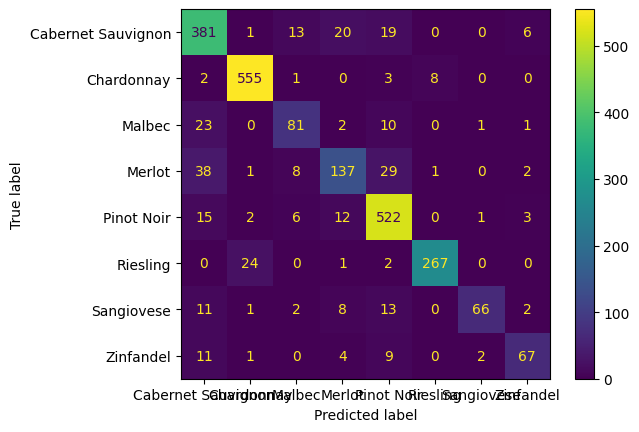

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_val,predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Cabernet Sauvignon" , "Chardonnay","Malbec","Merlot","Pinot Noir","Riesling","Sangiovese","Zinfandel"])

cm_display.plot()
plt.show()